# State Farm Distracted Driver Detection 
Based on the starter file from Otto group: https://github.com/ottogroup/statefarm

Getting started with the [State Farm Distracted Driver Detection](https://www.kaggle.com/c/state-farm-distracted-driver-detection) competition. We use [nolearn](https://github.com/dnouri/nolearn) and [Lasagne](https://github.com/Lasagne/Lasagne) for the neural network part.

The repository can be found [here](https://github.com/ottogroup/statefarm).

## Imports

In [73]:
#%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt
from lasagne import layers, updates, nonlinearities
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_saliency
from nolearn.lasagne import NeuralNet
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_loss
from sklearn.cross_validation import LabelKFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Conv2DLayer
from lasagne.layers import MaxPool2DLayer
from lasagne.nonlinearities import softmax
from lasagne.updates import adam
from lasagne.layers import get_all_params
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
import numpy as np
#from nolearn.lasagne import objectiv

In [29]:
from src.data import load_train_data
from src.data import load_test_data
from src.data import make_submission
from src.netutils import CVTrainSplit
from src.netutils import RotateBatchIterator

## Load data

In [4]:
IMG_SHAPE = 64, 64

In [5]:
path = '../input'

The `load_train_data` function will return `X_train` and `y_train` with the correct shape. `drivers` contains the driver ids for the images.

In [9]:
X_train, y_train, drivers = load_train_data(path, grayscale=False, img_shape=IMG_SHAPE)

Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9


In [10]:
X_train.shape, y_train.shape, drivers.shape

((22424, 3, 64, 64), (22424,), (22424,))

In [11]:
X_train, y_train, drivers = shuffle(X_train, y_train, drivers, random_state=0)

## Show some images

Note: We cropped the images to get a square size. They contain mostly the right side of the original images, as that side seems to contain the most useful information.

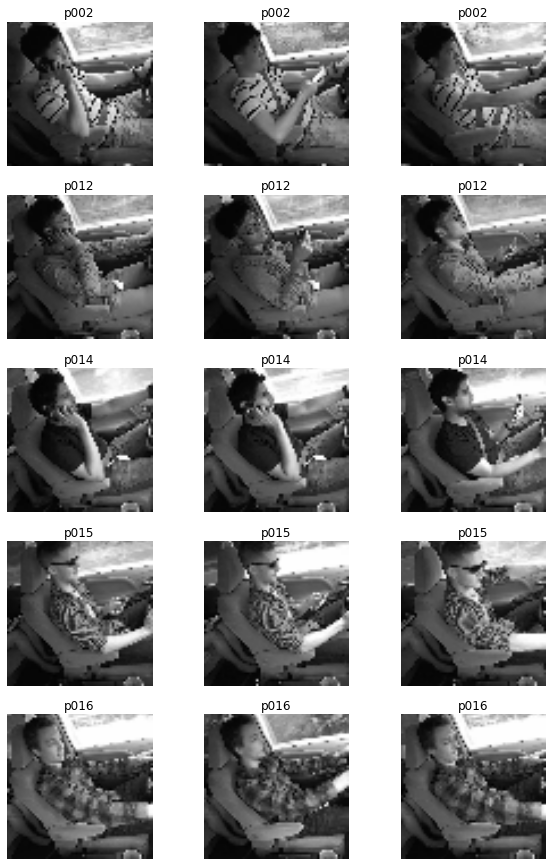

In [13]:
figs, axes = plt.subplots(5, 3, figsize=(10, 15))
[(ax.set_xticks([]), ax.set_yticks([]), ax.axis('off')) for ax in axes.flatten()]
for i, driver in enumerate(np.unique(drivers)[:5]):
    for j, n in enumerate(range(0, 300, 100)):
        axes[i, j].imshow(X_train[drivers==driver][n, 0], cmap='gray')
        axes[i, j].set_title(driver)

## Define the neural network

We pass a special train split to the `NeuralNet` instance so that the internal validation holds out 20% of the drivers for validation. This way, train and validation do not contain overlapping drivers. In practice, it is probably necessary to split several times for a more robust evaluation.

In [14]:
train_split = CVTrainSplit(LabelKFold(drivers, n_folds=5))

During training, we augment images by rotating them randomly in the range of -10 to 10 degrees. We rotate all images of a batch with a probability of 0.5.

In [15]:
batch_iterator_train = RotateBatchIterator(128, max_angle=10, rotate_prob=0.5)

The architecture is chosen to be not too deep for quick results. We use a lot of dropout layers and only one dense layer to combat overfitting, which is a huge problem in this competition.

In [16]:
layer = [
    (InputLayer, {'shape': (None, X_train.shape[1], X_train.shape[2], X_train.shape[3])}),

    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': 2}),
    (DropoutLayer, {}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': 2}),
    (DropoutLayer, {}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': 8}),
    (DropoutLayer, {}),

    (DenseLayer, {'num_units': 128}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
]

layers2 = [
    (InputLayer, {'shape': (None, X_train.shape[1], X_train.shape[2], X_train.shape[3])}),

    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': 2}),
    (DropoutLayer, {}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': 2}),
    (DropoutLayer, {}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': 2}),
    (DropoutLayer, {}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': 2}),
    (DropoutLayer, {}),
    
    #(DenseLayer, {'num_units': 128, 'nonlinearity': softmax}),
    #(DropoutLayer, {}),
    (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
]

In [17]:
net = NeuralNet(
    layers=layer, 
    update=adam,
    update_learning_rate=0.001,
    verbose=1,
    batch_iterator_train=batch_iterator_train,
    train_split=TrainSplit(eval_size=0.25),
    max_epochs=50,
)
#net0 = NeuralNet(
 #   layers=layers0,
  #  max_epochs=10,
#
 #   update=adagrad,
  #  update_learning_rate=0.0002,
#
 #   objective_l2=0.0025,
#
 #   train_split=TrainSplit(eval_size=0.25),
  #  verbose=1,
#)

## Train

In [18]:
net.fit(X_train, y_train)

# Neural Network with 160202 learnable parameters

## Layer information

  #  name        size
---  ----------  ---------
  0  input0      3x64x64
  1  conv2d1     32x64x64
  2  maxpool2d2  32x32x32
  3  dropout3    32x32x32
  4  conv2d4     64x32x32
  5  maxpool2d5  64x16x16
  6  dropout6    64x16x16
  7  conv2d7     128x16x16
  8  maxpool2d8  128x2x2
  9  dropout9    128x2x2
 10  dense10     128
 11  dropout11   128
 12  dense12     10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -------
      1     2.30776     2.30051    1.00315      0.11103  270.31s
      2     2.27302     2.19112    1.03738      0.19890  271.33s
      3     2.10443     1.91263    1.10028      0.33523  265.99s
      4     1.86872     1.61501    1.15710      0.42292  266.30s
      5     1.65747     1.39939    1.18442      0.50864  264.49s
      6     1.50172     1.16075    1.29375      0.61451  264.13s
      7     1.39983     1.02022    1.3720

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f409edbf1d0>,
     batch_iterator_train=<src.netutils.RotateBatchIterator object at 0x7f406b3da3c8>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 3, 64, 64)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'pad': 1, 'num_filters': 32, 'filter_size': (3, 3)}), (<class 'lasagne.layers.pool.MaxPool2DLayer'>, {'pool_size': 2}), (<class 'lasagne.layers.noise.DropoutLayer'>, {}), (...layers.dense.DenseLayer'>, {'nonlinearity': <function softmax at 0x7f4076b3e158>, 'num_units': 10})],
     loss=None, max_epochs=50, more_params={},
     objective=<function objective at 0x7f409d8fd048>,
     objective_loss_function=<function categorical_crossentropy at 0x7f409eedd6a8>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f4065707ac8>],
     on_training_finished=[],
     on_trai

## Analysis

### Plot loss functions

This allows us to visualize the extent of overfit and whether the loss has converged.

<module 'matplotlib.pyplot' from '/home/tinka/anaconda2/envs/py3k/lib/python3.5/site-packages/matplotlib/pyplot.py'>

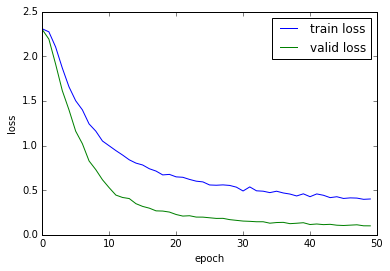

In [19]:
plot_loss(net)

### Critical image parts

This plot allows us to check which part of the image are most critical for making correct predictions. Does the net focus on important aspects such as the hand or face, or does it overfit on noise, such as the window?

<module 'matplotlib.pyplot' from '/home/tinka/anaconda2/envs/py3k/lib/python3.5/site-packages/matplotlib/pyplot.py'>

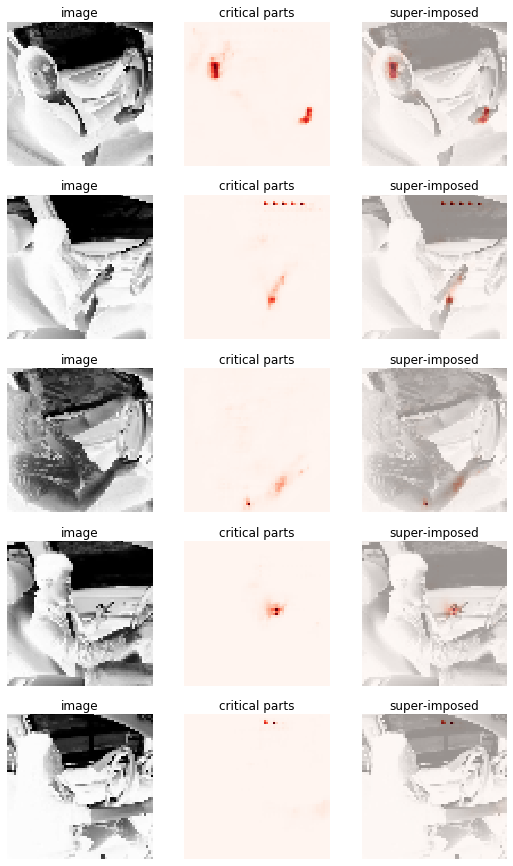

In [20]:
plot_occlusion(net, X_train[:5], y_train[:5])

### Confusion matrix

Here we check what classes the model struggles with predicting correctly.

In [22]:
_, X_valid, _, y_valid = net.train_split(X_train, y_train, net)

In [23]:
y_pred = net.predict(X_valid)

In [24]:
labels = [
    'safe driving',
    'texting - right',
    'talking on the phone - right',
    'texting - left',
    'talking on the phone - left',
    'operating the radio',
    'drinking',
    'reaching behind',
    'hair and makeup',
    'talking to passenger']

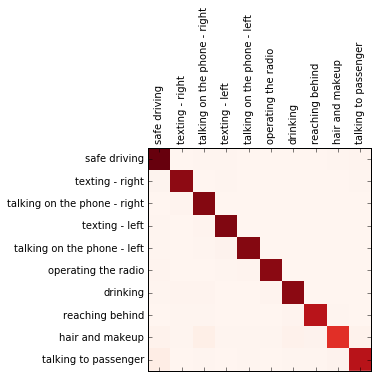

In [25]:
plt.matshow(confusion_matrix(y_valid, y_pred), cmap='Reds', interpolation='none')
plt.yticks(np.arange(10), labels)
plt.xticks(np.arange(10), labels, rotation=90);

In [77]:
net.save_weights_to('weights_05')

/home/tinka/anaconda2/envs/py3k/lib/python3.5/site-packages/nolearn/lasagne/base.py:793: UserWarning: The 'save_weights_to' method will be removed in nolearn 0.6. Please use 'save_params_to' instead.
  warn("The 'save_weights_to' method will be removed in nolearn 0.6. "


## Submission

Finally, we prepare a submission to Kaggle.

In [38]:
from src.data import load_test_data
import autoreload

%reload_ext autoreload
%autoreload

In [54]:
import os
import glob

import numpy as np
import pandas as pd
from skimage import io as sk_io
from skimage import transform as sk_transform
from skimage import color as sk_color

def _load_img(file, img_shape=(64, 64), grayscale=False):
    shape = list(img_shape) + [3]

    img = sk_io.imread(file)
    assert img.shape == (480, 640, 3)

    # crop to right side
    img = sk_transform.resize(img[:, -550:-70], shape)

    if grayscale:
        img = sk_color.rgb2gray(img)
    return img

def load_test_data(
        main_path,
        img_shape=(64, 64),
        swapaxes=True,
        grayscale=False,
        return_ids=False,
        min_img=None,
        max_img=None,
        prev=False,
        X_prev=None,
        ids_prev=None):

    """Load test data

    main_path : path to train/test folder

    img_shape=(64, 64) : desired output image size

    swapaxes=True : if True, reshape to N x Color x Height x Width

    grayscale=False : if True, convert to grayscale

    return_ids=False : whether image names should be returned

    max_img=None : if not None, only load first n images
    """

    X = []
    ids = []

    path = os.path.join(main_path, 'test', '*.jpg')
    files = glob.glob(path)
    c=0
    if max_img and min_img:
        files = files[min_img:max_img]
        c=min_img
    elif max_img:
        files = files[:max_img]
    elif min_img:
        files=files[min_img:]
        c=min_img
	
    
    for file in files:
        if c%1000==0:
            print("now at file",c)	
        img = _load_img(file, img_shape, grayscale)
        X.append(img)

        img_name = file.split(os.path.sep)[-1]
        ids.append(img_name)
        c+=1

    print("reshaping array")
    X = np.array(X).reshape(len(X), img_shape[0], img_shape[1], -1)
    print("make float32")
    X = X.astype(np.float32)
    print("load ids")
    ids = np.array(ids)

    if swapaxes:
        X = np.swapaxes(np.swapaxes(X, 2, 3), 1, 2)
    print("extend X and ids")
    if prev:
        X=np.concatenate((X_prev,X))
        ids=np.concatenate((ids_prev,ids))
    return X, ids

In [55]:
%autoreload 1
X_test, ids = load_test_data(path, grayscale=False, img_shape=IMG_SHAPE, max_img=100)
X_test, ids = load_test_data(path, grayscale=False, img_shape=IMG_SHAPE, min_img=100, max_img=200, prev=True, X_prev=X_test, ids_prev=ids)

now at file 0
reshaping array
make float32
load ids
extend X and ids
reshaping array
make float32
load ids
extend X and ids


In [56]:
print(X_test.shape)

(200, 3, 64, 64)


In [57]:
X_test, ids = load_test_data(path, grayscale=False, img_shape=IMG_SHAPE, max_img=10000)
X_test, ids = load_test_data(path, grayscale=False, img_shape=IMG_SHAPE, min_img=10000, max_img=20000, prev=True, X_prev=X_test, ids_prev=ids)
X_test, ids = load_test_data(path, grayscale=False, img_shape=IMG_SHAPE, min_img=20000, max_img=30000, prev=True, X_prev=X_test, ids_prev=ids)
X_test, ids = load_test_data(path, grayscale=False, img_shape=IMG_SHAPE, min_img=30000, max_img=40000, prev=True, X_prev=X_test, ids_prev=ids)
X_test, ids = load_test_data(path, grayscale=False, img_shape=IMG_SHAPE, min_img=40000, max_img=50000, prev=True, X_prev=X_test, ids_prev=ids)
X_test, ids = load_test_data(path, grayscale=False, img_shape=IMG_SHAPE, min_img=50000, max_img=60000, prev=True, X_prev=X_test, ids_prev=ids)
X_test, ids = load_test_data(path, grayscale=False, img_shape=IMG_SHAPE, min_img=60000, max_img=70000, prev=True, X_prev=X_test, ids_prev=ids)
X_test, ids = load_test_data(path, grayscale=False, img_shape=IMG_SHAPE, min_img=70000, prev=True, X_prev=X_test, ids_prev=ids)

now at file 0
now at file 1000
now at file 2000
now at file 3000
now at file 4000
now at file 5000
now at file 6000
now at file 7000
now at file 8000
now at file 9000
reshaping array
make float32
load ids
extend X and ids
now at file 10000
now at file 11000
now at file 12000
now at file 13000
now at file 14000
now at file 15000
now at file 16000
now at file 17000
now at file 18000
now at file 19000
reshaping array
make float32
load ids
extend X and ids
now at file 20000
now at file 21000
now at file 22000
now at file 23000
now at file 24000
now at file 25000
now at file 26000
now at file 27000
now at file 28000
now at file 29000
reshaping array
make float32
load ids
extend X and ids
now at file 30000
now at file 31000
now at file 32000
now at file 33000
now at file 34000
now at file 35000
now at file 36000
now at file 37000
now at file 38000
now at file 39000
reshaping array
make float32
load ids
extend X and ids
now at file 40000
now at file 41000
now at file 42000
now at file 43000
n

In [7]:
c=[1,2,3,4,5,6,7,8,9]
print(c[1:])

[2, 3, 4, 5, 6, 7, 8, 9]


In [58]:
y_proba = net.predict_proba(X_test)

In [59]:
make_submission('submissions/submission_05.csv', y_proba, ids)

## Further avenues

There is a clear path for further improving the score:
* Take larger and/or colored images (set `grayscale=False` when loading images).
* Use a better architecture -- a deeper net will probably yield better results.
* Augment images to combat overfitting.